### Aaron Olvier, UVA (ao9au)
### Anvar Sabarnov, UVA (as5da)
### Maurizio Boano, UVA (mb6fs)
### Monish Dadlani, UVA (mkd7q)

## DS5559 Final Project: Hotel Revenue Optimization

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import locale
import os
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, concat_ws, to_timestamp
from pyspark.sql.types import *
from pyspark.sql import functions as f
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, OneHotEncoderModel, VectorIndexer, StringIndexer, MaxAbsScaler, StandardScaler
from pyspark.ml import Pipeline

In [2]:
# set currency
locale.setlocale(locale.LC_ALL, '')

# read in raw data
hc = pd.read_csv("hotel_bookings.csv")

#### Records, columns counts

In [3]:
print("Number of records is {}".format(len(hc)))
print("Number of columns is {}".format(len(hc.columns)))

Number of records is 119390
Number of columns is 32


In [4]:
hc.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

#### Splitting categorical, continuous variables; describing

In [5]:
hc_categorical = hc[['hotel', 'is_canceled', 'arrival_date_month', 'is_repeated_guest',
                     'meal', 'country', 'market_segment', 'distribution_channel',
                     'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 
                     'deposit_type', 'customer_type', 'reservation_status']]

categoricals = ['hotel', 'is_canceled', 'arrival_date_month', 'is_repeated_guest',
                     'meal', 'country', 'market_segment', 'distribution_channel',
                     'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 
                     'deposit_type', 'customer_type', 'reservation_status']

hc_categorical = hc_categorical.apply(lambda x: x.astype('category'))

for x in categoricals:
    hc[x] = hc[x].astype('category')
    

hc[['company', 'agent']] = hc[['company', 'agent']].fillna(value=0)

hc['agent'] = np.where(hc.agent == 0, 0, 1)    
hc['company'] = np.where(hc.company == 0, 0, 1)    


hc = hc.dropna()

hc['children'] = hc['children'].astype(int)
hc['agent'] = hc['agent'].astype(int)
hc['company'] = hc['company'].astype(int)
hc['adr'] = hc['adr'].astype(int)

hc.drop(["reservation_status", "reservation_status_date"], axis = 1, inplace = True)

hc.to_csv(r'transformed_data.csv')

In [6]:
hc_categorical.describe()

,hotel,is_canceled,arrival_date_month,is_repeated_guest,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,119390,119390,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,2,12,2,5,177,8,5,2,10,12,3,4,3
top,City Hotel,0,August,0,BB,PRT,Online TA,TA/TO,0,A,A,No Deposit,Transient,Check-Out
freq,79330,75166,13877,115580,92310,48590,56477,97870,115580,85994,74053,104641,89613,75166


In [7]:
hc_numerical = hc[hc.columns.difference(hc_categorical.columns).tolist()]
hc_numerical.describe()

,adr,adults,agent,arrival_date_day_of_month,arrival_date_week_number,arrival_date_year,babies,booking_changes,children,company,days_in_waiting_list,lead_time,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,stays_in_week_nights,stays_in_weekend_nights,total_of_special_requests
count,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000
mean,101.798424,1.858391,0.865397,15.800880,27.166555,2016.157656,0.007948,0.221181,0.104207,0.055703,2.330754,104.311435,0.131634,0.087142,0.061885,2.502145,0.928897,0.571683
std,50.473686,0.578576,0.341300,8.780324,13.589971,0.707459,0.097380,0.652785,0.399172,0.229349,17.630452,106.903309,1.484672,0.845869,0.244172,1.900168,0.996216,0.792678
min,-6.000000,0.000000,0.000000,1.000000,1.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.000000,2.000000,1.000000,8.000000,16.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,95.000000,2.000000,1.000000,16.000000,28.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
75%,126.000000,2.000000,1.000000,23.000000,38.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,161.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1.000000
max,5400.000000,55.000000,1.000000,31.000000,53.000000,2017.000000,10.000000,21.000000,10.000000,1.000000,391.000000,737.000000,72.000000,26.000000,8.000000,41.000000,16.000000,5.000000


## Preprocessing

In [14]:
# MODULES, CONTEXT, AND PATHING
spark = SparkSession.builder \
        .master("local") \
        .appName("mllib_classifier") \
        .getOrCreate()

sc = spark.sparkContext

schema = [StructField('Index', IntegerType(), True),
            StructField('hotel', StringType(), True),
            StructField('is_canceled', IntegerType(), True),
            StructField('lead_time', IntegerType(), True),
            StructField('arrival_date_year', IntegerType(), True),
            StructField('arrival_date_month', StringType(), True),
            StructField('arrival_date_week_number', IntegerType(), True),
            StructField('arrival_date_day_of_month', IntegerType(), True),
            StructField('stays_in_weekend_nights', IntegerType(), True),
            StructField('stays_in_week_nights', IntegerType(), True),
            StructField('adults', IntegerType(), True),
            StructField('children', IntegerType(), True),
            StructField('babies', IntegerType(), True),
            StructField('meal', StringType(), True),
            StructField('country', StringType(), True),
            StructField('market_segment', StringType(), True),
            StructField('distribution_channel', StringType(), True),
            StructField('is_repeated_guest', IntegerType(), True),
            StructField('previous_cancellations', IntegerType(), True),
            StructField('previous_bookings_not_canceled', IntegerType(), True),
            StructField('reserved_room_type', StringType(), True),
            StructField('assigned_room_type', StringType(), True),
            StructField('booking_changes', IntegerType(), True),
            StructField('deposit_type', StringType(), True),
            StructField('agent', IntegerType(), True),
            StructField('company', IntegerType(), True),
            StructField('days_in_waiting_list', IntegerType(), True),
            StructField('customer_type', StringType(), True),
            StructField('adr', IntegerType(), True),
            StructField('required_car_parking_spaces', IntegerType(), True),
            StructField('total_of_special_requests', IntegerType(), True)]

final_struc = StructType(fields=schema)

df = spark.read.csv("transformed_data.csv", header = True, schema=final_struc)


In [15]:
categorical_columns = ['hotel', 'arrival_date_month',
                     'meal', 'country', 'market_segment', 'distribution_channel',
                      'reserved_room_type', 'assigned_room_type', 
                     'deposit_type', 'customer_type']

# The index of string values multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

# The encode of indexed vlaues multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

pipeline = Pipeline(stages=indexers + encoders)
model=pipeline.fit(df)
transformed = model.transform(df)

## Training, Testing, Validation Splits

In [16]:
# Create lookup table
months = spark.createDataFrame([('January', '1'), ('February', '2'),('March', '3'),('April', '4'), ('May', '5'), ('June', '6'),('July','7'), ('August', '8'),
                                ('September', '9'), ('October', '10'), ('November', '11'), ('December', '12')],['month_txt', 'month_num'])
# Join data to lookup table
transformed = transformed.join(months, transformed.arrival_date_month == months.month_txt).select(transformed['*'],months.month_num)
# Create data column
transformed = transformed.withColumn('arrival_date',concat_ws('/',transformed.month_num,transformed.arrival_date_day_of_month,transformed.arrival_date_year))
# Convert date string to datetime
transformed = transformed.withColumn('date', to_timestamp(transformed.arrival_date,'M/d/yyyy'))
# Add row number
transformed = transformed.withColumn('row_num', f.row_number().over(Window.orderBy(transformed.date)))
# Calculate percentile of row num
transformed = transformed.withColumn('perc_rank', f.percent_rank().over(Window.orderBy(transformed.row_num)))
# Create validation set
condition = col('perc_rank') > .8
validation = transformed.filter(condition)
transformed = transformed.filter(~condition)

In [17]:
cols = ['hotel_indexed', 'lead_time', 'arrival_date_year','arrival_date_month_indexed','arrival_date_week_number',
                                       'arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights','adults',
                                       'children','babies','meal_indexed','country_indexed','market_segment_indexed','distribution_channel_indexed','is_repeated_guest',
                                       'previous_cancellations','previous_bookings_not_canceled','reserved_room_type_indexed','assigned_room_type_indexed',
                                       'booking_changes','deposit_type_indexed','agent','company','days_in_waiting_list','customer_type_indexed','adr',
                                       'required_car_parking_spaces','total_of_special_requests']


assembler = VectorAssembler(inputCols=cols, outputCol="features") 
transformed = assembler.transform(transformed)
validation = assembler.transform(validation)

In [18]:
validation_data = validation.select(col("is_canceled").alias("label"), "features")
validation_data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [19]:
model_data = transformed.select(col("is_canceled").alias("label"), "features")
model_data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [20]:
training, test = model_data.randomSplit([0.75, 0.25], seed=314)

In [21]:
# validating splits

percent_training = training.selectExpr("count(*)/119258 AS percent_training").collect()[0][0]
percent_test = test.selectExpr("count(*)/119258 AS percent_test").collect()[0][0]
percent_validation = validation_data.selectExpr("count(*)/119258 AS percent_validation").collect()[0][0]

print("training: "+str(round(percent_training*100, 2))+"%")
print("test: "+str(round(percent_test*100, 2))+"%")
print("validation: "+str(round(percent_validation*100, 2))+"%")

training: 59.85%
test: 19.91%
validation: 19.94%


## Scaling Features

In [22]:
# Compute summary statistics and generate MaxAbsScalerModel based on training set
# scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

scalerModel = scaler.fit(training)

# Apply scaling to all three datasets and rename scaledFeatures to features column
scaled_training = scalerModel.transform(training)
scaled_training = scaled_training.selectExpr("label", "scaledFeatures AS features")

scaled_test = scalerModel.transform(test)
scaled_test = scaled_test.selectExpr("label", "scaledFeatures AS features")

scaled_validation = scalerModel.transform(validation_data)
scaled_validation = scaled_validation.selectExpr("label", "scaledFeatures AS features")

In [23]:
# scaled_training.show(1, False)

## Threshold Evaluation Function

In [24]:
# printing relevant assumptions

print("avg stay: {0} days".format(round((hc.stays_in_weekend_nights + hc.stays_in_week_nights).mean(), 2)))
print("avg daily rate: {0}".format(locale.currency(hc.adr.mean(), grouping = True)))

print("")
# https://www.law.cornell.edu/wex/overbooking
print("hotels are not legally allowed to overbook")
print("")
print("ASSUMPTIONS")
# https://www.hotelnewsnow.com/Articles/108398/STR-2016-Europe-hotel-performance
print("-70.6% occupancy rate (based on 2016 average for all of Europe)")
print("-$0 cancellation fee with full refund (so hotel is motivated to identify people who are likely to cancel)")
print("-50% response rate for both groups (not everyone answers our call/email)")
print("-70% capture rate for group that cancels (that they are willing to cancel at the time of contact)")
print("-25% of people who were not previously going to cancel will now cancel (due to us contacting them about cancelling)")

avg stay: 3.4 days
avg daily rate: $99.99

hotels are not legally allowed to overbook

ASSUMPTIONS
-70.6% occupancy rate (based on 2016 average for all of Europe)
-$0 cancellation fee with full refund (so hotel is motivated to identify people who are likely to cancel)
-50% response rate for both groups (not everyone answers our call/email)
-70% capture rate for group that cancels (that they are willing to cancel at the time of contact)
-25% of people who were not previously going to cancel will now cancel (due to us contacting them about cancelling)


In [25]:
# threshold function to maximize net revenue

def net_rev(df, thresholds = None, avg_adr = 101.80, occ_rate = 0.704, avg_stay = 3.43, resp = 0.5, timing = 0.7, loss = 0.25):
    if (type(thresholds) == list) or (type(thresholds) == np.ndarray):
        
        output = pd.DataFrame(columns = ['threshold', 'net_rev'])

        for i in thresholds:
            preds_and_labels = df.withColumn("prediction", f.when(df["prob_of_one"]>i, 1).otherwise(0)).selectExpr("prediction", "label")
            tp = preds_and_labels[(preds_and_labels.label == 1) & (preds_and_labels.prediction == 1)].count()
            fp = preds_and_labels[(preds_and_labels.label == 0) & (preds_and_labels.prediction == 1)].count()
            rev_gain = (tp*avg_adr*avg_stay*occ_rate*resp*timing) 
            rev_lost = (fp*avg_adr*avg_stay*(1-occ_rate)*resp*loss)
            net_rev = rev_gain - rev_lost
            output = output.append({'threshold' : i, 'net_rev' : net_rev}, ignore_index = True)

        best_thresh = output.iloc[output.net_rev.idxmax()]["threshold"]
        max_rev = output.net_rev.max()
        print("Optimal threshold to maximize revenue from options provided is: {0}".format(best_thresh))
        print("Estimated net revenue generated with best threshold is: {0}".format(locale.currency(max_rev, grouping = True)))
        plt.plot(output.threshold, output.net_rev, marker = "o")
        plt.plot(best_thresh, max_rev, "ro")
        plt.show()
        
        return output
    
    elif (type(thresholds) == float) or (type(thresholds) == int) :
        
        preds_and_labels = df.withColumn("prediction", f.when(df["prob_of_one"]>thresholds, 1).otherwise(0)).selectExpr("prediction", "label")
        tp = preds_and_labels[(preds_and_labels.label == 1) & (preds_and_labels.prediction == 1)].count()
        fp = preds_and_labels[(preds_and_labels.label == 0) & (preds_and_labels.prediction == 1)].count()
        rev_gain = (tp*avg_adr*avg_stay*occ_rate*resp*timing) 
        rev_lost = (fp*avg_adr*avg_stay*(1-occ_rate)*resp*loss)
        net_rev = rev_gain - rev_lost
        
        print("Estimated net revenue generated with given threshold is: {0}".format(locale.currency(net_rev, grouping = True)))
        
        return net_rev
    
    elif type(thresholds) == type(None):
        preds_and_labels = df.selectExpr("CAST(prediction AS int) AS prediction", "label")
        tp = preds_and_labels[(preds_and_labels.label == 1) & (preds_and_labels.prediction == 1)].count()
        fp = preds_and_labels[(preds_and_labels.label == 0) & (preds_and_labels.prediction == 1)].count()
        rev_gain = (tp*avg_adr*avg_stay*occ_rate*resp*timing) 
        rev_lost = (fp*avg_adr*avg_stay*(1-occ_rate)*resp*loss)
        net_rev = rev_gain - rev_lost
        
        print("Estimated net revenue generated with given threshold is: {0}".format(locale.currency(net_rev, grouping = True)))
        
        return net_rev

## Logistic

In [26]:
# Train a log model.
lr = LogisticRegression(maxIter=100)

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[lr])

# Create Parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.5, 1]) \
    .addGrid(lr.elasticNetParam, [0,.5, 1]) \
    .build()

# crossvalidator object
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),
                          numFolds=5)

# Train model.  This also runs the indexer.
log_model = crossval.fit(training)

In [27]:
params = [{p.name: v for p, v in m.items()} for m in log_model.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {log_model.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, log_model.avgMetrics)
])

,areaUnderPR,regParam,elasticNetParam
0,0.800938,0.0,0.0
1,0.800938,0.0,0.5
2,0.800938,0.0,1.0
3,0.779028,0.5,0.0
4,0.362963,0.5,0.5
5,0.362963,0.5,1.0
6,0.772279,1.0,0.0
7,0.362963,1.0,0.5
8,0.362963,1.0,1.0


In [28]:
log_bestModel = log_model.bestModel

print("regParam: "+str(log_bestModel.stages[0]._java_obj.getRegParam()))
print("elasticNetParam: "+str(log_bestModel.stages[0]._java_obj.getElasticNetParam()))

regParam: 0.0
elasticNetParam: 0.0


In [29]:
log_model_train = log_model.transform(training)

firstelement = udf(lambda v:float(v[1]),FloatType())

log_model_train = log_model_train.withColumn("prob_of_one", firstelement(log_model_train["probability"]))

log_model_train.show(5)

+-----+--------------------+--------------------+--------------------+----------+-----------+
|label|            features|       rawPrediction|         probability|prediction|prob_of_one|
+-----+--------------------+--------------------+--------------------+----------+-----------+
|    0|(29,[0,1,2,3,4,5,...|[1.12342605729826...|[0.75462366176101...|       0.0| 0.24537633|
|    0|(29,[0,1,2,3,4,5,...|[0.12434998414663...|[0.53104749926392...|       0.0|  0.4689525|
|    0|(29,[0,1,2,3,4,5,...|[3.87804160075870...|[0.97972814383751...|       0.0|0.020271856|
|    0|(29,[0,1,2,3,4,5,...|[1.43510924111494...|[0.80769614665969...|       0.0| 0.19230385|
|    0|(29,[0,1,2,3,4,5,...|[0.77764350727047...|[0.68517201371638...|       0.0| 0.31482798|
+-----+--------------------+--------------------+--------------------+----------+-----------+
only showing top 5 rows



Optimal threshold to maximize revenue from options provided is: 0.1
Estimated net revenue generated with best threshold is: $1,722,634.01


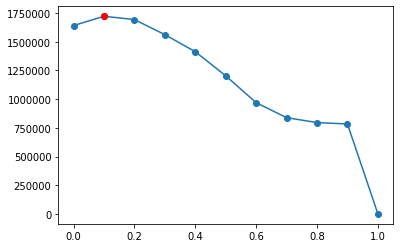

In [30]:
thresh = np.linspace(0, 1, 11)
rev_out = net_rev(log_model_train, thresh)

Optimal threshold to maximize revenue from options provided is: 0.11111111111111112
Estimated net revenue generated with best threshold is: $1,727,514.97


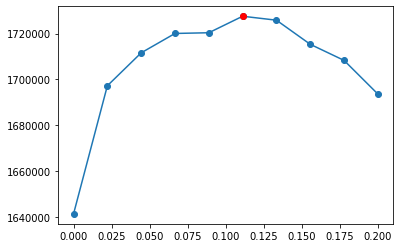

In [31]:
thresh = np.linspace(0, 0.2, 10)
rev_out = net_rev(log_model_train, thresh)

In [32]:
log_preds = log_model.transform(test)
# preds.show(5, False)

firstelement = udf(lambda v:float(v[1]),FloatType())

log_preds = log_preds.withColumn("prob_of_one", firstelement(log_preds["probability"]))

log_preds.show(5)

+-----+--------------------+--------------------+--------------------+----------+-----------+
|label|            features|       rawPrediction|         probability|prediction|prob_of_one|
+-----+--------------------+--------------------+--------------------+----------+-----------+
|    0|(29,[0,1,2,3,4,5,...|[0.95612340905522...|[0.72234497608597...|       0.0| 0.27765504|
|    0|(29,[0,1,2,3,4,5,...|[1.39968846961180...|[0.80213444873702...|       0.0| 0.19786555|
|    0|(29,[0,1,2,3,4,5,...|[0.38523124647473...|[0.59513419381072...|       0.0|  0.4048658|
|    0|(29,[0,1,2,3,4,5,...|[1.60982193800076...|[0.83338666339023...|       0.0| 0.16661334|
|    0|(29,[0,1,2,3,4,5,...|[0.44243704275597...|[0.60883957579755...|       0.0| 0.39116043|
+-----+--------------------+--------------------+--------------------+----------+-----------+
only showing top 5 rows



In [33]:
log_test_rev = net_rev(log_preds, 0.1111)

Estimated net revenue generated with given threshold is: $567,439.18


## Random Forest

In [34]:
# Train a RandomForest model.
rf = RandomForestClassifier(featuresCol="features", maxBins = 178, seed = 314)

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[rf])

# Create Parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [25, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# crossvalidator object
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),
                          numFolds=5)

# Train model.  This also runs the indexer.
rf_model = crossval.fit(training)

In [35]:
params = [{p.name: v for p, v in m.items()} for m in rf_model.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {rf_model.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, rf_model.avgMetrics)
])

,areaUnderPR,numTrees,maxDepth
0,0.856748,25,5
1,0.907081,25,10
2,0.927675,25,15
3,0.863931,50,5
4,0.906976,50,10
5,0.928565,50,15
6,0.864061,100,5
7,0.907861,100,10
8,0.929406,100,15


In [36]:
# Print the coefficients and intercept for logistic regression
rf_bestModel = rf_model.bestModel

print("numTrees: "+str(rf_bestModel.stages[0]._java_obj.getNumTrees()))
print("maxDepth: "+str(rf_bestModel.stages[0]._java_obj.getMaxDepth()))

numTrees: 100
maxDepth: 15


In [37]:
rf_model_train = rf_model.transform(training)

firstelement = udf(lambda v:float(v[1]),FloatType())

rf_model_train = rf_model_train.withColumn("prob_of_one", firstelement(rf_model_train["probability"]))

rf_model_train.show(5)

+-----+--------------------+--------------------+--------------------+----------+-----------+
|label|            features|       rawPrediction|         probability|prediction|prob_of_one|
+-----+--------------------+--------------------+--------------------+----------+-----------+
|    0|(29,[0,1,2,3,4,5,...|[90.4171347605121...|[0.90417134760512...|       0.0| 0.09582865|
|    0|(29,[0,1,2,3,4,5,...|[73.7224755704808...|[0.73722475570480...|       0.0| 0.26277524|
|    0|(29,[0,1,2,3,4,5,...|[91.0113177378398...|[0.91011317737839...|       0.0| 0.08988682|
|    0|(29,[0,1,2,3,4,5,...|[96.5074816712155...|[0.96507481671215...|       0.0|0.034925185|
|    0|(29,[0,1,2,3,4,5,...|[82.8024416942744...|[0.82802441694274...|       0.0| 0.17197558|
+-----+--------------------+--------------------+--------------------+----------+-----------+
only showing top 5 rows



Optimal threshold to maximize revenue from options provided is: 0.2
Estimated net revenue generated with best threshold is: $2,057,795.72


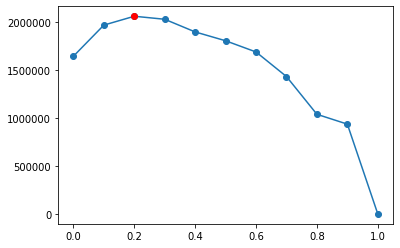

In [38]:
thresh = np.linspace(0, 1, 11)
rev_out_rf = net_rev(rf_model_train, thresh)

Optimal threshold to maximize revenue from options provided is: 0.24
Estimated net revenue generated with best threshold is: $2,070,713.63


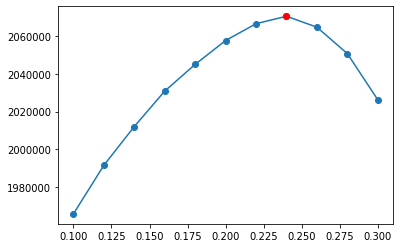

In [39]:
thresh = np.linspace(0.1, 0.3, 11)
rev_out_rf = net_rev(rf_model_train, thresh)

In [40]:
rf_preds = rf_model.transform(test)

firstelement = udf(lambda v:float(v[1]),FloatType())

rf_preds = rf_preds.withColumn("prob_of_one", firstelement(rf_preds["probability"]))

rf_preds.show(5)

+-----+--------------------+--------------------+--------------------+----------+-----------+
|label|            features|       rawPrediction|         probability|prediction|prob_of_one|
+-----+--------------------+--------------------+--------------------+----------+-----------+
|    0|(29,[0,1,2,3,4,5,...|[92.4636384723068...|[0.92463638472306...|       0.0| 0.07536361|
|    0|(29,[0,1,2,3,4,5,...|[81.6890396509672...|[0.81689039650967...|       0.0|  0.1831096|
|    0|(29,[0,1,2,3,4,5,...|[91.0206262084822...|[0.91020626208482...|       0.0|0.089793734|
|    0|(29,[0,1,2,3,4,5,...|[95.1946927117639...|[0.95194692711763...|       0.0|0.048053075|
|    0|(29,[0,1,2,3,4,5,...|[89.3037379567077...|[0.89303737956707...|       0.0| 0.10696262|
+-----+--------------------+--------------------+--------------------+----------+-----------+
only showing top 5 rows



In [41]:
# calc revenue with chosen threshold
rf_test_rev = net_rev(rf_preds, 0.24)

Estimated net revenue generated with given threshold is: $645,689.70


## SVM

In [42]:
# Train an svm model.
svm = LinearSVC(maxIter=10)

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[svm])

# Create Parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0, .1, .5, 1]) \
    .build()

# crossvalidator object
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),
                          numFolds=5)

# Train model. This also runs the indexer.
svm_model = crossval.fit(scaled_training)

In [43]:
params = [{p.name: v for p, v in m.items()} for m in svm_model.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {svm_model.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, svm_model.avgMetrics)
])

,areaUnderPR,regParam
0,0.800103,0.0
1,0.801067,0.1
2,0.770326,0.5
3,0.752993,1.0


In [44]:
svm_bestModel = svm_model.bestModel

print("regParam: "+str(svm_bestModel.stages[0]._java_obj.getRegParam()))

regParam: 0.1


In [45]:
svm_model_train = svm_model.transform(scaled_training)

firstelement = udf(lambda v:float(v[1]),FloatType())

svm_model_train = svm_model_train.withColumn("prob_of_one", firstelement(svm_model_train["rawPrediction"]))

svm_model_train.show(5)

+-----+--------------------+--------------------+----------+-----------+
|label|            features|       rawPrediction|prediction|prob_of_one|
+-----+--------------------+--------------------+----------+-----------+
|    0|[1.40318950943545...|[1.06879752804605...|       0.0| -1.0687975|
|    0|[1.40318950943545...|[0.87585717645758...|       0.0| -0.8758572|
|    0|[1.40318950943545...|[1.40447139249621...|       0.0| -1.4044714|
|    0|[1.40318950943545...|[1.05621249373544...|       0.0| -1.0562125|
|    0|[1.40318950943545...|[0.94546532855054...|       0.0| -0.9454653|
+-----+--------------------+--------------------+----------+-----------+
only showing top 5 rows



In [46]:
svm_model_train.selectExpr("MAX(prob_of_one) as max", "MIN(prob_of_one) as min").show()

+--------+---------+
|     max|      min|
+--------+---------+
|6.786682|-5.130853|
+--------+---------+



Optimal threshold to maximize revenue from options provided is: -2.0
Estimated net revenue generated with best threshold is: $1,642,034.17


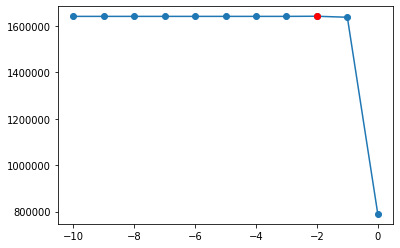

In [47]:
thresh = np.linspace(-10, 0, 11)
rev_out_svm = net_rev(svm_model_train, thresh)

Optimal threshold to maximize revenue from options provided is: -1.2
Estimated net revenue generated with best threshold is: $1,719,729.16


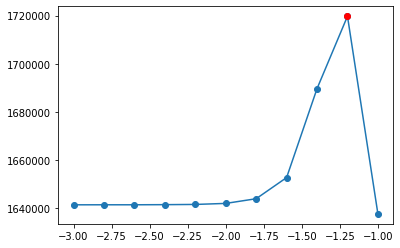

In [48]:
thresh = np.linspace(-3, -1, 11)
rev_out_svm = net_rev(svm_model_train, thresh)

In [49]:
svm_preds = svm_model.transform(scaled_test)

firstelement = udf(lambda v:float(v[1]),FloatType())

svm_preds = svm_preds.withColumn("prob_of_one", firstelement(svm_preds["rawPrediction"]))

svm_preds.show(5)

+-----+--------------------+--------------------+----------+-----------+
|label|            features|       rawPrediction|prediction|prob_of_one|
+-----+--------------------+--------------------+----------+-----------+
|    0|[1.40318950943545...|[0.88693729786396...|       0.0| -0.8869373|
|    0|[1.40318950943545...|[0.96650262029906...|       0.0| -0.9665026|
|    0|[1.40318950943545...|[0.84483129849850...|       0.0| -0.8448313|
|    0|[1.40318950943545...|[1.01762735378767...|       0.0| -1.0176274|
|    0|[1.40318950943545...|[0.80567584171932...|       0.0|-0.80567586|
+-----+--------------------+--------------------+----------+-----------+
only showing top 5 rows



In [50]:
# calc revenue with chosen threshold
svm_test_rev = net_rev(svm_preds, -1.2)

Estimated net revenue generated with given threshold is: $564,883.29


## Model Comparison & Evaluation on Test Set

In [51]:
test_rev_df = pd.DataFrame(
    columns = ["model", "net revenue at optimal threshold", "rev_format"],
    data = [
        ["logistic", log_test_rev, locale.currency(log_test_rev, grouping = True)],
        ["random forest", rf_test_rev, locale.currency(rf_test_rev, grouping = True)],
        ["svm", svm_test_rev, locale.currency(svm_test_rev, grouping = True)]
    ]
)

In [52]:
fig = px.bar(test_rev_df, x='model', y='net revenue at optimal threshold', text = "rev_format")
fig.update_layout(template = "plotly")
fig.update_traces(marker_color=['#eb5600', '#1a9988', '#eb5600'])
fig.show()

In [53]:
fig.write_image("rev_out.jpg", height = 500, width =900)

## Deploy Champion Model on Validation Set

In [54]:
rf_preds_val = rf_model.transform(validation_data)

firstelement = udf(lambda v:float(v[1]),FloatType())

rf_preds_val = rf_preds_val.withColumn("prob_of_one", firstelement(rf_preds_val["probability"]))

rf_preds_val.show(5)

+-----+--------------------+--------------------+--------------------+----------+-----------+
|label|            features|       rawPrediction|         probability|prediction|prob_of_one|
+-----+--------------------+--------------------+--------------------+----------+-----------+
|    0|(29,[1,2,3,4,5,6,...|[98.6546272665825...|[0.98654627266582...|       0.0|0.013453728|
|    0|(29,[1,2,3,4,5,6,...|[97.4005530653766...|[0.97400553065376...|       0.0|0.025994468|
|    0|(29,[1,2,3,4,5,6,...|[98.6546272665825...|[0.98654627266582...|       0.0|0.013453728|
|    0|(29,[1,2,3,4,5,6,...|[98.7544152822984...|[0.98754415282298...|       0.0|0.012455847|
|    0|(29,[1,2,3,4,5,6,...|[80.9547473177963...|[0.80954747317796...|       0.0| 0.19045253|
+-----+--------------------+--------------------+--------------------+----------+-----------+
only showing top 5 rows



In [55]:
# calc additional revenue with chosen threshold and RF model on validation set
rf_validation_rev = net_rev(rf_preds_val, 0.24)

Estimated net revenue generated with given threshold is: $679,253.49
